# Control Run Analysis

Computation of the potential prognostic predictability (PPP) for metrics from the control simulation, eventually using pre-built functions in project folder. 

**Important metrics:** <br>
- SH sea ice extent/volume
- regional sea ice extent/volume
- regional NPP, PCO2, SSS, SST
- gridpoint-level fields for sea ice concentration, SST, SSS, NPP, PCO2
- sea ice edge position (latitude at which sea ice concentration drops below 15%)

**Steps:** <br>
- open dataset, including all files in control directory for specified variable
- compute climatology
- compute anomalies
- compute variance &emsp; $\sigma^{2} = \frac{\sum (X - \mu)^{2}}{N}$
- write this dataset to a NetCDF file

In [161]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

### Functions

In [326]:
## compute the climatology (time mean for each month)
def compute_clim(da):
    time = 'time'
    try:
        clim = da.groupby('time.month').mean(dim='time')
    except:
        time = time.upper()
        clim = da.groupby(time+'.month').mean(dim=time)
    
    clim = clim.rename(da.name+'_clim')
    return clim

## compute the monthly anomalies from the 300-year control runs
def compute_anom(da):
    time = 'time'
    try:
        clim = da.groupby('time.month').mean(dim='time')
    except:
        time = time.upper()
        clim = da.groupby(time+'.month').mean(dim=time)
        
    anom = da.groupby(time+'.month') - clim
    anom = anom.rename(da.name+'_anom')
    return anom

## compute the variance
def compute_variance(da): 
    time = 'time'
    try:
        clim = da.groupby('time.month').mean(dim='time')
    except:
        time = time.upper()
        clim = da.groupby(time+'.month').mean(dim=time)
        
    anom = da.groupby(time+'.month') - clim
    
    variance = anom.groupby(time+'.month').var(dim=time)
    variance = variance.rename(da.name+'_variance')
    return variance

## save climatology data
def save_ctrl_clim(var, da, write_rootdir, subdir, regional):
    if regional == False:
        filename = var.lower()+'_ctrl_global_climatology.nc'
    elif regional == True:
        filename = var.lower()+'_ctrl_so_climatology.nc'
    else:
        print('the parameter \'regional\' must be boolean')
        return

    da.to_netcdf(write_rootdir+subdir+var.upper()+'/'+filename)

# Analysis

**First grab ```geolon_t``` and ```geolat_t``` from ocean model grid data. These coordinates will be added to all variables so that regional masks can be applied later on.**

In [155]:
subdir_grid = 'GRID/'

ocean_grid = xr.open_dataset(rootdir+subdir_grid+'ocean.static.nc')

geolat_t = ocean_grid.geolat_t
geolon_t = ocean_grid.geolon_t

## Gridpoint-level Fields

In [317]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'

subdir_ctrl = 'CTRL/'

#### Sea Surface Temperature (SST)

In [201]:
path_sst = rootdir+subdir_ctrl+'/SST/sst_*.nc'
var_sst = 'sst'

ds_sst = xr.open_mfdataset(path_sst)

In [294]:
ds_sst

<xarray.Dataset>
Dimensions:     (nv: 2, time: 3600, xt_ocean: 360, xu_ocean: 360, yt_ocean: 200, yu_ocean: 200)
Coordinates:
    geolat_c    (yu_ocean, xu_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolon_c    (yu_ocean, xu_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    geolon_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0001-01-16 12:00:00 ... 0300-12-16 12:00:00
  * xt_ocean    (xt_ocean) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * xu_ocean    (xu_ocean) float64 -279.0 -278.0 -277.0 ... 78.0 79.0 80.0
  * yt_ocean    (yt_ocean) float64 -81.5 -80.5 -79.5 -78.5 ... 87.5 88.5 89.5
  * yu_ocean    (yu_ocean) float64 -81.0 -80.0 -79.0 -78.0 ... 88.0 89.0 90.0
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T1  (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2  (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    sst         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 200, 360), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    filename:   ocean.000101-000512.sst.nc
    title:      ESM2M_pi-control_topaz_C3_verona_NEWDIAG_V4
    grid_type:  mosaic
    grid_tile:  1
    history:    Sun Dec 22 16:11:24 2019: ncks -4 -L 1 -a -O decadal_predicti...
    NCO:        netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net,...

In [289]:
sst_attrs = ds_sst[var_sst].attrs
sst_metrics_attrs = {'long_name':'Potential Temperature', 'units':sst_attrs['units'], 'valid range':sst_attrs['valid_range'],
                    'coordinates':'geolon_t, geolat_t'}

sst_clim = compute_clim(ds_sst[var_sst])
sst_clim.attrs = sst_metrics_attrs
sst_clim.attrs['description'] = 'sea surface temperature monthly climatology'

sst_anom = compute_anom(ds_sst[var_sst])
sst_anom.attrs = sst_metrics_attrs
sst_anom.attrs['description'] = 'sea surface temperature monthly anomaly'

sst_variance = compute_variance(ds_sst[var_sst])
sst_variance.attrs = {'long_name':'Potential Temperature Variance', 'units':sst_attrs['units']+' ^2', 'coordinates':'geolon_t, geolat_t',
                      'description':'variance of sea surface temperature monthly anomaly'}

In [324]:
save_ctrl_clim(var_sst, sst_clim, write_rootdir, subdir_ctrl, regional=True)

In [325]:
os.listdir(write_rootdir+subdir_ctrl+'SST/')

['sst_ctrl_regional_climatology.nc',
 'ocean.static.nc',
 'sst_ctrl_global_climatology.nc',
 'SST_raw']

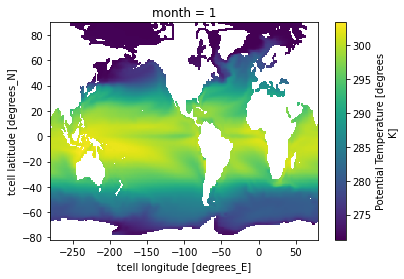

In [203]:
sst_clim[0].plot()

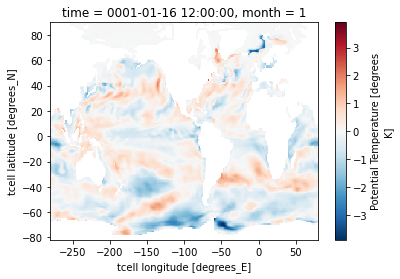

In [204]:
sst_anom[0].plot()

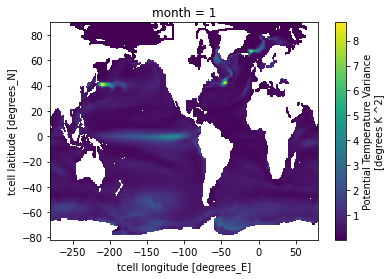

In [206]:
sst_variance[0].plot()

#### Sea Surface Salinity (SSS)

In [207]:
path_sss = rootdir+subdir_ctrl+'/SSS/sss_*.nc'
var_sss = 'sss'

ds_sss = xr.open_mfdataset(path_sss)

## add geolon_t and geolat_t coordinates
ds_sss = ds_sss.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [268]:
sss_attrs = ds_sss[var_sss].attrs
sss_metrics_attrs = {'long_name':'Practical Salinity', 'units':'psu', 'valid_range':sss_attrs['valid_range'],
                    'coordinates':'geolon_t, geolat_t'}

sss_clim = compute_clim(ds_sss[var_sss])
sss_clim.attrs = sss_metrics_attrs
sss_clim.attrs['description'] = 'sea surface salinity monthly climatology'

sss_anom = compute_anom(ds_sss[var_sss])
sss_anom.attrs = sss_metrics_attrs
sss_anom.attrs['description'] = 'sea surface salinity monthly anomaly'

sss_variance = compute_variance(ds_sss[var_sss])
sss_variance.attrs = {'long_name':'Practical Salinity Variance', 'units':'psu ^2', 'coordinates':'geolon_t, geolat_t', 
                     'description':'variance of sea surface salinity monthly anomaly'}

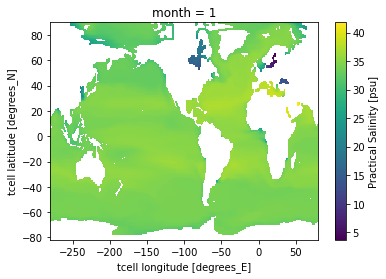

In [209]:
sss_clim[0].plot()

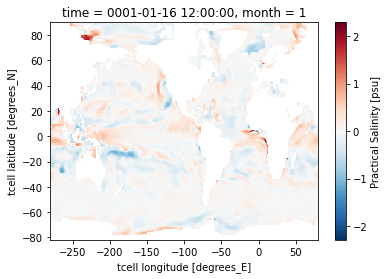

In [210]:
sss_anom[0].plot()

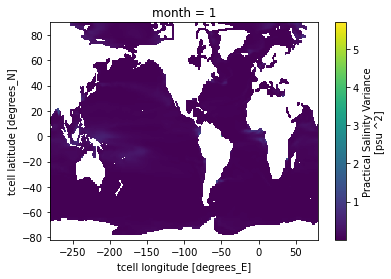

In [211]:
sss_variance[0].plot()

#### Sea-ice Concentration (CN)
Already summed over all thickness categories (```CN_INV``` variable).

In [212]:
path_cn = rootdir+subdir_ctrl+'/CN/CN_inv_*.nc'
var_cn = 'CN_INV'

ds_cn = xr.open_mfdataset(path_cn)

## change XT / YT to ocean model grid coordinates xt_ocean / yt_ocean
ds_cn = ds_cn.rename({'XT':'xt_ocean', 'YT':'yt_ocean', 'TIME':'time'})
ds_cn = ds_cn.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

## add geolon_t and geolat_t coordinates
ds_cn = ds_cn.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [275]:
cn_attrs = ds_cn[var_cn].attrs
cn_metrics_attrs = {'long_name': 'CN[K=@SUM]', 'long_name_mod': 'Z=-0.05:1.3', 'valid_range':np.arange(0,2,1,dtype=np.float32),
                    'coordinates':'geolon_t, geolat_t'}

cn_clim = compute_clim(ds_cn[var_cn])
cn_clim.attrs = cn_metrics_attrs
cn_clim.attrs['description'] = 'sea ice concentration monthly climatology'

cn_anom = compute_anom(ds_cn[var_cn])
cn_anom.attrs = cn_metrics_attrs
cn_anom.attrs['description'] = 'sea ice concentration monthly anomaly'

cn_variance = compute_variance(ds_cn[var_cn])
cn_variance.attrs = {'long_name': 'CN[K=@SUM] Variance', 'long_name_mod': 'Z=-0.05:1.3 Variance', 'coordinates':'geolon_t, geolat_t', 
                    'description':'variance of sea ice concentration monthly anomaly'}

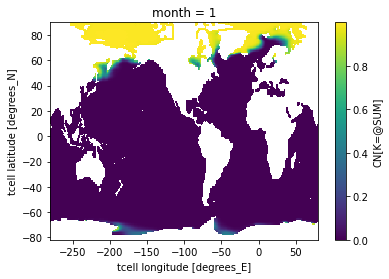

In [214]:
cn_clim[0].plot()

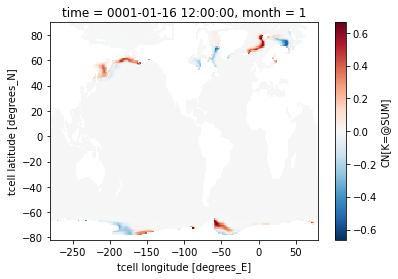

In [215]:
cn_anom[0].plot()

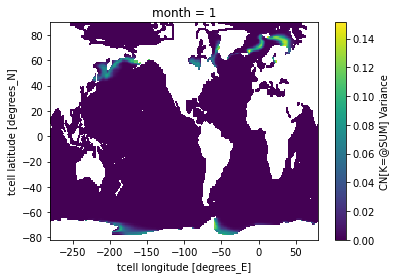

In [216]:
cn_variance[0].plot()

#### Net Primary Production (NPP)
***What are the units here?***

In [217]:
path_npp = rootdir+subdir_ctrl+'/NPP/NPP_*.nc'
var_npp = 'NPP'

ds_npp = xr.open_mfdataset(path_npp)

## rename coordinates for continuity
ds_npp = ds_npp.rename({'XT_OCEAN':'xt_ocean', 'YT_OCEAN':'yt_ocean', 'TIME':'time'})

## add geolon_t and geolat_t coordinates
ds_npp = ds_npp.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [276]:
npp_attrs = ds_npp[var_npp].attrs
npp_metrics_attrs = {'long_name':'Net Primary Production', 'long_name_full': npp_attrs['long_name'], 'coordinates':'geolon_t, geolat_t'}

npp_clim = compute_clim(ds_npp[var_npp])
npp_clim.attrs = npp_metrics_attrs
npp_clim.attrs['description'] = 'net primary production monthly climatology'

npp_anom = compute_anom(ds_npp[var_npp])
npp_anom.attrs = npp_metrics_attrs
npp_anom.attrs['description'] = 'net primary production monthly anomaly'

npp_variance = compute_variance(ds_npp[var_npp])
npp_variance.attrs = {'long_name':'Net Primary Production Variance', 'long_name_full': npp_attrs['long_name'],
                      'coordinates':'geolon_t, geolat_t', 'description':'variance of net primary production monthly anomaly'}

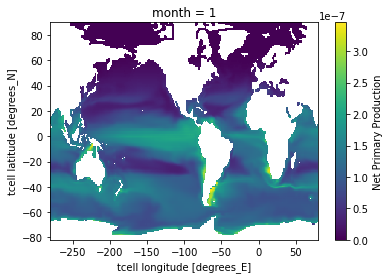

In [228]:
npp_clim[0].plot()

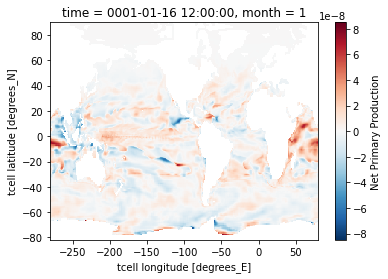

In [229]:
npp_anom[0].plot()

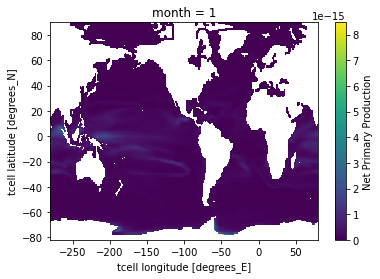

In [230]:
npp_variance[0].plot()

#### Surface pCO$_2$ (PCO2SURF)

In [222]:
path_pco2surf = rootdir+subdir_ctrl+'/PCO2SURF/pco2surf_*.nc'
var_pco2surf = 'pco2surf'

ds_pco2surf = xr.open_mfdataset(path_pco2surf)

In [283]:
pco2surf_attrs = ds_pco2surf[var_pco2surf].attrs
pco2surf_metrics_attrs = {'long_name': 'Oceanic pCO2', 'units': 'uatm', 'coordinates':'geolon_t, geolat_t'}

pco2surf_clim = compute_clim(ds_pco2surf[var_pco2surf])
pco2surf_clim.attrs = pco2surf_metrics_attrs
pco2surf_clim.attrs['description'] = 'oceanic surface pCO2 monthly climatology'

pco2surf_anom = compute_anom(ds_pco2surf[var_pco2surf])
pco2surf_anom.attrs = pco2surf_metrics_attrs
pco2surf_anom.attrs['description'] = 'oceanic surface pCO2 monthly anomaly'

pco2surf_variance = compute_variance(ds_pco2surf[var_pco2surf])
pco2surf_variance.attrs = {'long_name': 'Oceanic pCO2 Variance', 'units': 'uatm ^2', 'coordinates':'geolon_t, geolat_t', 
                          'description':'variance of oceanic surface pCO2 monthly anomaly'}

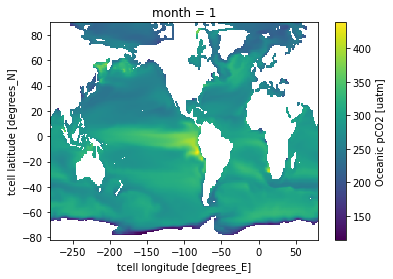

In [224]:
pco2surf_clim[0].plot()

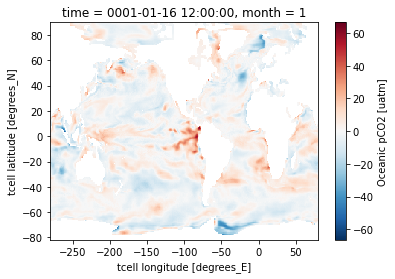

In [225]:
pco2surf_anom[0].plot()

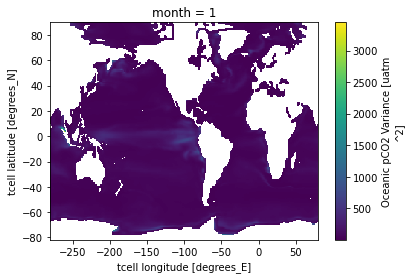

In [226]:
pco2surf_variance[0].plot()

## Southern Hemisphere Sea Ice Extent and Volume
Using sea concentration extent (CN_INV) and sea ice thickness (HI) with ocean/ice model grid information.

### Sea Ice Extent

In [30]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'

**First create regional masks from ocean model grid.**

In [31]:
subdir_grid = 'GRID/'

# ice_grid = xr.open_dataset(rootdir+subdir_grid+'ice_month.static.nc')
ocean_grid = xr.open_dataset(rootdir+subdir_grid+'ocean.static.nc')

In [36]:
## Southern Ocean mask
SouthernOcean_mask = xr.where(ocean_grid.geolat_t < -40, 1, 0)

## Weddell Sea region mask
Weddell_mask = xr.where(ocean_grid.geolon_t > -60, 1, 0)
Weddell_mask = xr.where(ocean_grid.geolon_t < 20, Weddell_mask, 0)
Weddell_mask = xr.where(SouthernOcean_mask > 0, Weddell_mask, 0)

## Indian Ocean region mask
Indian_mask = xr.where(ocean_grid.geolon_t > 20, 1, 0)
Indian_mask = xr.where(ocean_grid.geolon_t < -270, 1, Indian_mask)
Indian_mask = xr.where(SouthernOcean_mask > 0, Indian_mask, 0)

## West Pacific Ocean region mask
WestPacific_mask = xr.where(ocean_grid.geolon_t > -270, 1, 0)
WestPacific_mask = xr.where(ocean_grid.geolon_t < -200, WestPacific_mask, 0)
WestPacific_mask = xr.where(SouthernOcean_mask > 0, WestPacific_mask, 0)

## Ross Sea region mask
Ross_mask = xr.where(ocean_grid.geolon_t > -200, 1, 0)
Ross_mask = xr.where(ocean_grid.geolon_t < -130, Ross_mask, 0)
Ross_mask = xr.where(SouthernOcean_mask > 0, Ross_mask, 0)

## Amundsen Sea and Bellingshausen Sea region mask
AmundBell_mask = xr.where(ocean_grid.geolon_t > -130, 1, 0)
AmundBell_mask = xr.where(ocean_grid.geolon_t < -60, AmundBell_mask, 0)
AmundBell_mask = xr.where(SouthernOcean_mask > 0, AmundBell_mask, 0)

In [45]:
# Weddell_mask.where(SIE_area[0] >= 0).plot()
# Indian_mask.where(SIE_area[0] >= 0).plot()
# WestPacific_mask.where(SIE_area[0] >= 0).plot()
# Ross_mask.where(SIE_area[0] >= 0).plot()
# AmundBell_mask.where(SIE_area[0] >= 0).plot()

**Compute SIE.**

In [46]:
subdir_ctrl = 'CTRL/'

path_cn = rootdir+subdir_ctrl+'/CN/CN_inv_*.nc'
cn_ds = xr.open_mfdataset(path_cn)

In [47]:
## create mask for SIE where SIC > 15%
SIE_binary = xr.where(cn_ds.CN_INV > 0.15, 1, 0)

## replace values over land with NaN
SIE_binary = xr.where(np.isnan(cn_ds.CN_INV), np.nan, SIE_binary)

## change coordinates to match ocean model grid (make compatible for areal integral)
SIE_binary = SIE_binary.rename({'XT':'xt_ocean', 'YT':'yt_ocean'})
SIE_binary = SIE_binary.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

## add metadata
SIE_binary.name = 'SIE_binary'
SIE_binary.attrs = {'long_name':'Sea Ice Extent (binary threshold @ >15% SIC)'}

In [48]:
## gridpoint ice extent area
SIE_area = SIE_binary * ocean_grid.area_t

## limit to just the Southern Hemisphere (for summation purposes)
SH_SIE_area = SIE_area.where(SouthernOcean_mask == 1)

## SIE areal integral for each month of the 300-year control simulation
SIE_sum = SH_SIE_area.sum(dim={'xt_ocean', 'yt_ocean'})

## SIE climatology - single areal integral (total area covered by sea ice in Southern Hemisphere)
SIE_sum_clim = SH_SIE_area.sum(dim={'xt_ocean', 'yt_ocean'}).groupby('TIME.month').mean(dim='TIME')

## SIE anomaly - single area sum
SIE_sum_anom = SIE_sum.groupby('TIME.month') - SIE_sum_clim


## SIE climatology - field (values at individual grid points)
# SIE_field_clim = SH_SIE_area.groupby('TIME.month').mean(dim='TIME')

## SIE anomaly - field
# SIE_field_anom = SH_SIE_area.groupby('TIME.month') - SIE_field_clim

In [89]:
## total ice extent in Southern Hemisphere averaged over each month for the 300-year control simulation
SIE_sum_clim.values

array([1.14894449e+12, 2.31606270e+11, 6.33947916e+11, 2.32585935e+12,
       5.55895083e+12, 8.61570736e+12, 1.10150784e+13, 1.27363297e+13,
       1.35743413e+13, 1.34102337e+13, 1.13414214e+13, 6.12370689e+12])

In [90]:
## monthly anomalies of total ice extent in Southern Hemisphere for the 300-year control simulation
SIE_sum_anom.values

array([ 2.19518421e+11,  1.25396031e+10, -1.09078505e+11, ...,
       -2.14585523e+11, -6.06563805e+11,  4.99528575e+10])

### Sea Ice Volume
**Use sea ice concentration!**

In [49]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir_ctrl = 'CTRL/'

path_hi = rootdir+subdir_ctrl+'/HI/HI_0001_0300.nc'
hi_ds = xr.open_mfdataset(path_hi)

HI = hi_ds.HI.rename({'xt':'xt_ocean', 'yt':'yt_ocean'})
HI = HI.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

In [55]:
hi_ds['HI'].attrs

{'long_name': 'ice thickness',
 'units': 'm-ice',
 'cell_methods': 'time: mean',
 'time_avg_info': 'average_T1,average_T2,average_DT'}

In [122]:
CN_INV = cn_ds.CN_INV

## change coordinates to match ocean model grid (make compatible for areal integral)
CN_INV = CN_INV.rename({'TIME':'time', 'XT':'xt_ocean', 'YT':'yt_ocean'})
CN_INV = CN_INV.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

In [133]:
## gridpoint sea ice area (no thresholding)
SI_area = CN_INV * ocean_grid.area_t

## gridpoint sea ice volume (SIV)
SIV_area = SI_area * HI

## limit to just the Southern Hemisphere (for summation purposes)
SH_SIV_area = SIV_area.where(SouthernOcean_mask == 1)

## SIV areal integral for each month of the 300-year control simulation
SIV_sum = SH_SIV_area.sum(dim={'xt_ocean', 'yt_ocean'})

## SIV climatology - single areal integral (total volume of ice in Southern Hemisphere)
SIV_sum_clim = SH_SIV_area.sum(dim={'xt_ocean', 'yt_ocean'}).groupby('time.month').mean(dim='time')

## SIV anomaly - single area sum
SIV_sum_anom = SIV_sum.groupby('time.month') - SIE_sum_clim

**Quick Check:** Sea ice thickness is mostly less than 1 meter in the Southern Hemisphere, so SIV values are less than SIC values. (see below for plot of grid cells with sea ice thickness greater than 1 meter)

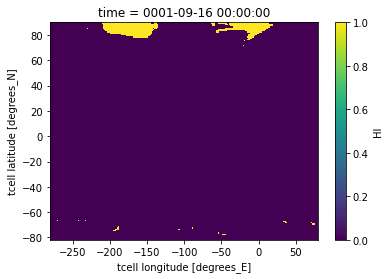

In [51]:
threshold = 1
month = 8      # September should be around peak sea ice in Southern Ocean
HI_clim = HI.groupby('time.month').mean(dim='time')

t = xr.where(HI[month] > threshold, 1, 0)
# t = xr.where(np.isnan(HI_clim[month]), np.nan, t)
t.plot()